Transformer及其衍生架构，在自然语言处理上取得了卓越的成果。但是，在将这一范式迁移到时间序列预测上来的时候，却遇到了尴尬的打不过线性模型的困难

首先我们分析一下，NLP（自然语言处理）和TSF（时间序列预测）两个问题的主要差别：

1. 自然语言中的语义既存在在每个单词中，也存在在单词之间的序列关系上。一个句子完全打乱单词顺序，也能保留部分信息（尽管不那么准确）。一个还不懂语法的语言学习者，仅靠单词也可以和其他人勉强交流。但是对于时间序列，打乱顺序就意味着完全丢失信息，可以说时间序列的信息绝大部分都隐藏在序列之中。

2. 自然语言的具有高度的一致性和可迁移性，常见单词和词组的含义在绝大多数语料中都是相近相似的，虽然会有一些多义词但毕竟是少数。而不同的时间序列即使出现了相同的形态，也不能说就有相似含义。例如，在金融领域，某些价格形态会包含价格趋势信息，其底层的逻辑是多空双方的博弈导致的，但是如果这样的形态出现在例如气温序列中，就不能说表示趋势性，因为底层的逻辑完全不一样。

3. 自然语言的训练集非常丰富，在人类历史上积累了大量的训练语料。但由于时间序列的含义差距，每个领域的时间序列是有限的，只能使用当前研究的框架内的数据。一般资产的数据有10年以上已经是非常丰富的历史了。如果扩展序列就会面临结构和范式的变化。

4. 自然语言的模式迁移非常缓慢，几乎可以忽略不记，虽然人类的语言会有所发展和变化，但是这种变化都是以数十年为单位的，在短期内改变的只会有少数词的词义，大的语法是不会改变的。但对于金融数据。概念漂移是非常常见的，时间序列的底层因素，例如次贷危机、疫情的出现很可能直接导致资产的模式完全改变，从而让历史数据的价值大打折扣，进一步加剧了数据量的问题。

Transformer架构能在NLP上取得成功的原因，恰恰也是Transformer架构不能被直接迁移到TSF上的原因：

1. RNN架构的顺序结构会影响长距离信息传递，长距离信息要么随着梯度消失，要么产生梯度爆炸。为了能顺利捕捉长距离关系，Transformer架构可以放弃了RNN架构的顺序性，转而使用并行性保护远距离信息可以顺利传播；

2. 因为采用了并行架构丢失了顺序信息，Transformer架构采用位置编码补齐丢失的顺序信息。但位置编码会影响一部分原始语义信息；

3. 因为训练语料足够丰富，导致位置编码的影响可以被最小化；

4. 平行架构也可以充分运用算力，大幅度加速训练过程，因此可以接受更复杂的模型层数。将牺牲的部分通过更大的模型来弥补。

换言之，因为自然语言的训练资料足够丰富，足以掩盖Transformer架构的缺点，充分发挥Transformer架构的优势，才使得Transformer架构得以在NLP问题上大放异彩。但反过来，在TSF问题上，Transformer架构并没有这样的优势。而其劣势，会被时间序列数据量缺乏的问题放大。Transformer架构本身就很复杂，模型的参数量越大，需要的数据集也就越大，超大的模型可以轻松记忆本就为数不多的数据集导致过拟合，必须对扩展模型保持谨慎态度。

当然，这也并不意味着完全就不能使用Transformer架构。Transformer架构在长距离提取上仍然有优势。具体来说，如果想要充分发挥Transformer架构的优势，我们需要解决如下问题：

1. 每个信息单元包含的信息要足够丰富。自然语言中每个单词的语义已经非常丰富，最新的的大语言模型单个词嵌入维度已经达到了4096甚至更高。而单个时间步的OHLCV数据的维度太小，即使扩展一些辅助信息，也很难从单个时间步得到有效信息进行相互传播。因此，单个信息单元要从时间步提升到子序列级别，比如一个长达10天的子序列，除了10天本身的价格信息以外，还能抽象出某种趋势信息，例如一小段缩量上涨、或者一小段区间的放量震荡等等。通过将多个时间步组合成一个patch的方式，模型可以变为处理一段一段的时间。同时，这样的结构也可以接入更长的历史窗口，绕开Transformer在注意力层的O(N^2)复杂度的限制。

2. 用科学的方式扩展训练集，如果我们的目标是资产价格预测，那么至少训练集的范围可以扩展到其他金融资产，但不应该扩展到非金融的领域。因为价格的底层逻辑是供需关系、多空博弈。同时，还要增加额外的机制让模型理解不同资产之间的差距和联系，例如波动率、相关性、协整性等等。



In [16]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
class Patch_TST(nn.Module):
    """Patch Time Series Transformer"""
    def __init__(self, input_size, seq_len, patch_size, stride, num_layer, num_head, d_model, masking_ratio, mask_expand_size, dropout_1, dropout_2, dropout_3):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.stride = stride
        self.masking_ratio = masking_ratio
        self.mask_expand_size = mask_expand_size

        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.patch = TimeSeriesPatcher(patch_size, stride) # 首先经过patcher分成子序列

        self.projection = PatchProjection(input_size, patch_size, d_model = d_model, dropout = dropout_1)

        self.encoder = MultiLayerEncoder(dim_feature = d_model, dim_sequence = self.num_patch, num_enc_layer = num_layer, num_head = num_head, num_ffn_hidden = d_model*2, dropout = dropout_2)

        self.reconstruction = nn.Linear(d_model, input_size * patch_size)
        
        self.output = nn.Sequential(
            nn.Flatten(start_dim = -2),
            nn.Dropout(dropout_3),
            HybridDecoder(dim_state = self.num_patch * d_model, init_prob = [0.0,0.5,0.0])
        )
    
    def self_supervised(self, x):
        """
        自监督预训练
        如果不允许patch重叠，正好被patch隔断的形态无法学习到。
        允许patch重叠，则模型预训练的时候可以从前后patch偷看到信息。
        需要用双重mask
        target mask 是真正需要重建的patch
        input mask 是target mask的扩展，根据系数向两侧扩展掩蔽范围。例如假如patch允许重叠50%，则向前后各多屏蔽一个patch就可以完全屏蔽掉信息。
        """
        device = x.device
        batch_size = x.shape[0]
        noise = torch.rand(size=(batch_size, self.num_patch), device=device)
        target_mask = noise < self.masking_ratio
        
        # 防止出现所有 patch 都没被 mask 的情况，至少 mask 一个随机选择一个 patch 进行 mask
        if not target_mask.any(dim=1).all():
            for i in range(batch_size):
                if not target_mask[i].any():
                    fallback_idx = torch.randint(0, self.num_patch, (1,)).item()
                    target_mask[i, fallback_idx] = True

        target_mask_float = target_mask.float().unsqueeze(1)
        kernel_size = 2 * self.mask_expand_size + 1
        kernel = torch.ones(1, 1, kernel_size, device=device)
        padding = self.mask_expand_size
        expanded_mask_float = F.conv1d(target_mask_float, kernel, padding=padding)
        input_mask = (expanded_mask_float > 0).squeeze(1)


        x_patched = self.patch(x)
        reshape_mask = input_mask.unsqueeze(-1)
        x_masked = torch.where(reshape_mask, 0.0, x_patched)
        x_projected = self.projection(x_masked)
        x_encodered = self.encoder(x_projected)
        
        x_pre_reconstruction = x_encodered[target_mask] # 仅关注target mask
        x_reconstructed = self.reconstruction(x_pre_reconstruction)
        x_target = x_patched[target_mask] # 仅关注target mask

        return x_reconstructed, x_target
    
    def forward(self, x):
        """前向传播输出"""
        x_patched = self.patch(x)
        x_projected = self.projection(x_patched)
        x_encodered = self.encoder(x_projected)
        output = self.output(x_encodered)
        return output

最佳loss:  0.4705164486562813
最佳超参数:  {'seq_len': 167, 'patch_size': 8, 'num_layer': 5, 'num_head': 4, 'd_model': 256, 'dropout_1': 0.06083887034277233, 'dropout_2': 0.47287983228742475, 'batch_size': 32, 'learning_rate': 0.00015270328956060018, 'weight_decay': 1.8471832110248454e-06, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}

In [ ]:
def objective(trial):

    # 超参数
    seq_len = trial.suggest_int("seq_len", 60, 250)
    patch_size = trial.suggest_int("patch_size", 5, 30)
    # patch_size = trial.suggest_int("patch_size", 3,7)

    num_layer = trial.suggest_categorical('num_layer', [3,4,5])
    num_head = trial.suggest_categorical('num_head', [4,8,16])
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    
    dropout_1 = trial.suggest_float("dropout_1", 0.0, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0.0, 0.5)
    dropout_3 = 0.2

    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    assets_list_all = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
    assets_list_cfx = ['IH.CFX', 'IF.CFX', 'IC.CFX',]
    # assets_list = trial.suggest_categorical("assets_list", [assets_list_cfx, assets_list_all])

    assets_list = assets_list_all

    # 预训练目标 这两个超参数是比较特殊的，不能随机选择
    # 掩码的比例是预训练的难度，随机选择这个参数不公平
    # 步长则关系到模型能从前后的序列中偷看到多少的的信息，对预训练也至关重要
    
    # stride = patch_size # no overlap
    # masking_ratio = 0.2 # 可以设置较小的遮蔽率，因为模型完全不能偷看，只要遮蔽率是固定的，对其他超参数选择就是公平的

    if patch_size % 2 == 0:
        stride = patch_size // 2
    else:
        stride = patch_size // 2 + 1
     # 50 overlap
    masking_ratio = 0.2
    mask_expand_size = 1

    # 提取数据
    feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
    label_columns = ['label_return','down_prob','middle_prob','up_prob']

    
    # 加载数据
    feature = []
    label = []
    for asset_code in assets_list:
        data = pd.read_csv(f'data/{asset_code}.csv')
        feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
        label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

    feature = torch.stack(feature, dim = 1)
    label = torch.stack(label, dim = 1)
    feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
    label = label[seq_len-1:]
    data = RandomLoader(feature, label)
    train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])



    loss_fn = nn.MSELoss()
    model = Patch_TST(input_size = 10,
                    seq_len = seq_len,

                    patch_size = patch_size,
                    stride = stride,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,

                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,

                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


    def epoch():
        train_losses = []
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            train_losses.append(loss.item()) 
            loss.backward()
            optimizer.step()
        
        test_losses = []
        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                x_reconstructed, x_target = model.self_supervised(batch_x)
                loss = loss_fn(x_reconstructed, x_target)
                test_losses.append(loss.item()) 
        return np.mean(train_losses), np.mean(test_losses)

    def train(epochs = 100):
        train_losses = []
        test_losses = []
        for i in tqdm.tqdm(range(epochs)):
            train_loss, test_loss = epoch()
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            scheduler.step()
        # plt.plot(range(epochs), train_losses)
        # plt.plot(range(epochs), test_losses)
        # plt.show()
        return np.mean(test_losses[-10:])

    final_loss = train(100)

    return final_loss

In [20]:
study = optuna.create_study(
    direction="minimize",
    study_name="patchtst_pretrain_allassets",
    storage="sqlite:///data/db.sqlite3_pretrain_allassets",  # 保存到 SQLite 文件
    load_if_exists=True # 如果存在同名study，则加载它
)
study.optimize(objective, n_trials=30)


print("最佳试验的编号: ", study.best_trial.number)
print("最佳loss: ", study.best_value)
print("最佳超参数: ", study.best_params)
df = study.trials_dataframe()
df.sort_values(by='value')

[I 2025-10-06 03:54:26,751] A new study created in RDB with name: patchtst_pretrain_allassets
100%|██████████| 30/30 [01:43<00:00,  3.45s/it]
[I 2025-10-06 03:56:10,459] Trial 0 finished with value: 0.9911627271970114 and parameters: {'seq_len': 198, 'patch_size': 20, 'num_layer': 4, 'num_head': 4, 'd_model': 64, 'dropout_1': 0.1077006620185002, 'dropout_2': 0.18273773845488994, 'batch_size': 128, 'learning_rate': 0.0056160013539349124, 'weight_decay': 7.322827451533781e-05, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}. Best is trial 0 with value: 0.9911627271970114.
100%|██████████| 30/30 [01:19<00:00,  2.64s/it]
[I 2025-10-06 03:57:29,858] Trial 1 finished with value: 1.0290571266734923 and parameters: {'seq_len': 234, 'patch_size': 20, 'num_layer': 3, 'num_head': 4, 'd_model': 256, 'dropout_1': 0.11057250560341964, 'dropout_2': 0.48749631053973885, 'batch_size': 128, 'learning_rate': 0.00011032435554840727, 'weight_decay': 0.00029361880906062654, 'assets_list': ['IH.CFX', 'IF.CFX'

最佳试验的编号:  28
最佳loss:  0.8334856875737507
最佳超参数:  {'seq_len': 201, 'patch_size': 6, 'num_layer': 4, 'num_head': 8, 'd_model': 128, 'dropout_1': 0.430750132907638, 'dropout_2': 0.3188753052962336, 'batch_size': 32, 'learning_rate': 0.0006217087784242358, 'weight_decay': 4.38344777009637e-05, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE', 'RB.SHF', 'HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE']}


,number,value,datetime_start,datetime_complete,duration,params_assets_list,params_batch_size,params_d_model,params_dropout_1,params_dropout_2,params_learning_rate,params_num_head,params_num_layer,params_patch_size,params_seq_len,params_weight_decay,state
28,28,0.833486,2025-10-06 04:50:24.977061,2025-10-06 04:54:18.992960,0 days 00:03:54.015899,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",32,128,0.430750,0.318875,0.000622,8,4,6,201,0.000044,COMPLETE
17,17,0.867923,2025-10-06 04:37:41.806667,2025-10-06 04:38:47.270819,0 days 00:01:05.464152,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.296492,0.312678,0.000452,8,4,9,190,0.000920,COMPLETE
24,24,0.871989,2025-10-06 04:46:01.921854,2025-10-06 04:47:04.681439,0 days 00:01:02.759585,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.327397,0.224650,0.000283,8,4,8,178,0.000134,COMPLETE
27,27,0.876076,2025-10-06 04:49:24.799639,2025-10-06 04:50:24.965357,0 days 00:01:00.165718,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.432272,0.285472,0.000575,8,4,7,171,0.000048,COMPLETE
15,15,0.879191,2025-10-06 04:35:06.190371,2025-10-06 04:36:23.899901,0 days 00:01:17.709530,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.284969,0.272330,0.000403,8,5,10,175,0.000887,COMPLETE
21,21,0.891825,2025-10-06 04:42:26.311416,2025-10-06 04:43:30.757761,0 days 00:01:04.446345,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.209448,0.207830,0.000357,8,4,9,181,0.000476,COMPLETE
20,20,0.899886,2025-10-06 04:41:26.477965,2025-10-06 04:42:26.300014,0 days 00:00:59.822049,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.224541,0.214674,0.000322,8,4,9,179,0.000467,COMPLETE
25,25,0.905432,2025-10-06 04:47:04.692754,2025-10-06 04:48:01.726903,0 days 00:00:57.034149,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.407711,0.365209,0.000250,8,4,7,214,0.000166,COMPLETE
14,14,0.909058,2025-10-06 04:33:51.166289,2025-10-06 04:35:06.178220,0 days 00:01:15.011931,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.290613,0.416874,0.000547,16,5,10,163,0.000875,COMPLETE
16,16,0.911277,2025-10-06 04:36:23.911749,2025-10-06 04:37:41.795278,0 days 00:01:17.883529,"[IH.CFX, IF.CFX, IC.CFX, AU.SHF, JM.DCE, RB.SH...",128,256,0.273843,0.261123,0.000189,8,5,9,166,0.000253,COMPLETE


In [ ]:
df = study.trials_dataframe()
df.to_csv('result.csv')
df.sort_values(by='value')

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

最佳loss:  0.4705164486562813
最佳超参数:  {'seq_len': 167, 'patch_size': 8, 'num_layer': 5, 'num_head': 4, 'd_model': 256, 'dropout_1': 0.06083887034277233, 'dropout_2': 0.47287983228742475, 'batch_size': 32, 'learning_rate': 0.00015270328956060018, 'weight_decay': 1.8471832110248454e-06, 'assets_list': ['IH.CFX', 'IF.CFX', 'IC.CFX']}

ALL: 
seq_len = 170
patch_size = 8
num_layer = 4
num_head = 8
d_model = 256
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
stride = 4 # patch_size // 2  奇数再(+1)
masking_ratio = 0.2
mask_expand_size = 1

CFX: 
seq_len = 160
patch_size = 8
num_layer = 5
num_head = 4
d_model = 256
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']
stride = 4 # patch_size // 2  奇数再(+1)
masking_ratio = 0.2
mask_expand_size = 1

100%|██████████| 30/30 [01:03<00:00,  2.13s/it]


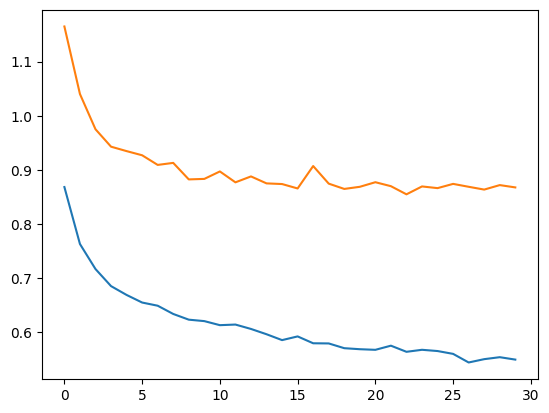

In [22]:
# 这些参数是两阶段共享的
seq_len = 170
patch_size = 8
num_layer = 4
num_head = 8
d_model = 256

assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
# assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX']

stride = 4 # patch_size // 2  奇数再(+1)
masking_ratio = 0.2
mask_expand_size = 1


# 这些参数是可变的
batch_size = 128

dropout_1 = 0.3
dropout_2 = 0.3
dropout_3 = 0.2

learning_rate = 0.0005
weight_decay = 1e-04


# 提取数据
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']

feature = []
label = []
for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
data = RandomLoader(feature, label)
train_loader, test_loader = data(batch_size=batch_size, slice_size=[0.5,0.4], balance=[True, False])


loss_fn = nn.MSELoss()
model = Patch_TST(input_size = 10,
                    seq_len = seq_len,
                    patch_size = patch_size,
                    stride = stride,
                    num_layer = num_layer, 
                    num_head = num_head,
                    d_model = d_model,
                    masking_ratio = masking_ratio,
                    mask_expand_size = mask_expand_size,
                    dropout_1 = dropout_1,
                    dropout_2 = dropout_2,
                    dropout_3 = dropout_3,
                    ).to('cuda:0')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


def epoch():
    train_losses = []
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        x_reconstructed, x_target = model.self_supervised(batch_x)
        loss = loss_fn(x_reconstructed, x_target)
        train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
        
    test_losses = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            x_reconstructed, x_target = model.self_supervised(batch_x)
            loss = loss_fn(x_reconstructed, x_target)
            test_losses.append(loss.item()) 
    return np.mean(train_losses), np.mean(test_losses)

def train(epochs = 30):
    train_losses = []
    test_losses = []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()
    plt.plot(range(epochs), train_losses)
    plt.plot(range(epochs), test_losses)
    plt.show()
    return np.mean(test_losses[-10:])


train(30)
torch.save(model.state_dict(), 'params/self_supervised_allasset.params')